In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re

import os

import pandas as pd
from reconchess import GameHistory, WinReason
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import json

In [27]:
def draw_graph(data, width=0.9, **kwargs):
    # Draw graph
    X = list(data.keys())
    cat = list(data.values())[0].keys()
      
    X_axis = np.arange(len(X)) 
    
    for ind, key in enumerate(cat):
        bottom = np.zeros_like(data.values())
        for subkey in list(data.values())[0][key].keys():
            val = [r[key][subkey] for r in data.values()]
            plt.bar(X_axis + width*((2*ind+1)/len(cat) - 1)/2, val, width/len(cat), label = key+subkey, bottom=bottom)
            
            bottom = val
      
    plt.xticks(X_axis, X) 
    plt.xlabel(kwargs.get("x_label")) 
    plt.title(kwargs.get("title")) 
    plt.legend() 
    plt.show()

In [30]:
def analyse(path):
    
    games = os.listdir(path)
    
    games = [os.path.join(path, game_id, f"game_{game_id}.log") for game_id in games]
    
    games = [x for x in games if os.path.exists(x)]
    game_hists: List[GameHistory] = [GameHistory.from_file(x) for x in games]
    
    print(f"Total games: {len(game_hists)}")
    
    print(f"Games won: {sum([(game.get_white_player_name() == 'Zubat') == game.get_winner_color() for game in game_hists])}")
    
    opponents = (
        {game.get_white_player_name() for game in game_hists}.union(
        {game.get_black_player_name() for game in game_hists}) -
        {"Zubat"}
    )
    print(f"Opponents: {opponents}")
    
    grouped_games = {
        opp: [game for game in game_hists if game.get_white_player_name() == opp or game.get_black_player_name() == opp]
        for opp in opponents
    }
    lengths = {
        opp: {
            "wins": {"": np.average([game.num_turns() for game in games if (game.get_white_player_name() == "Zubat") == game.get_winner_color()])},
            "losses": {"": np.average([game.num_turns() for game in games if (game.get_white_player_name() == "Zubat") != game.get_winner_color()])}
        }
        for opp, games in grouped_games.items()
    }
    # print(f"Game lengths: \n{json.dumps(lengths, indent=2)}")
    results = {
        opp: {
            "wins": {
                " via king capture": len([game for game in games if (((game.get_white_player_name() == "Zubat") == game.get_winner_color()) and game.get_win_reason() == WinReason.KING_CAPTURE)]),
                " via timeout": len([game for game in games if (((game.get_white_player_name() == "Zubat") == game.get_winner_color()) and game.get_win_reason() != WinReason.KING_CAPTURE)]),
            },
            "losses": {
                " via king capture": len([game for game in games if (((game.get_white_player_name() == "Zubat") != game.get_winner_color()) and game.get_win_reason() == WinReason.KING_CAPTURE) and (game.get_winner_color() is not None)]),
                " via timeout": len([game for game in games if (((game.get_white_player_name() == "Zubat") != game.get_winner_color()) and game.get_win_reason() != WinReason.KING_CAPTURE) and (game.get_winner_color() is not None)]),
            },
            "ties": {
                "": len([game for game in games if game.get_winner_color() is None])
            }
        }
        for opp, games in grouped_games.items()
    }
    
    print(np.unique([game.get_win_reason().name for group in grouped_games.values() for game in group]))
    print([game.get_winner_color() for group in grouped_games.values() for game in group if (game.get_win_reason() == WinReason.MOVE_LIMIT)])
    
    draw_graph(results, x_label="Bots", title="Final Tests\nresults grouped by bots")
    draw_graph(lengths, x_label="Bots", title="Final Tests\ngame lengths grouped by bots")

Total games: 197
Games won: 156
Opponents: {'trout', 'Châteaux', 'attacker', 'random', 'StrangeFish2'}
['KING_CAPTURE' 'MOVE_LIMIT' 'TIMEOUT']
[None, None]


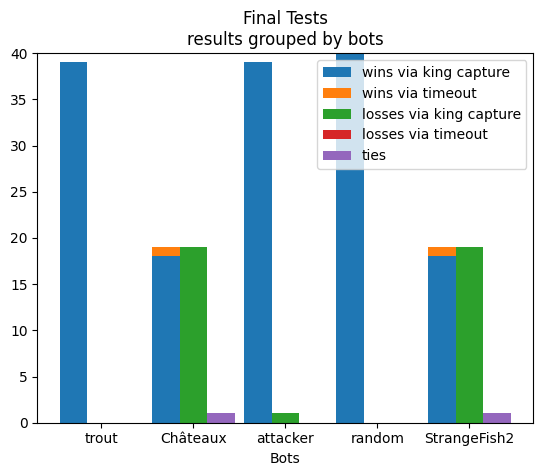

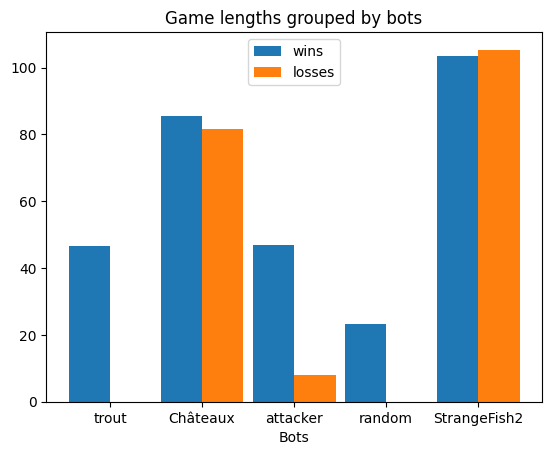

In [31]:
analyse("game_logs/ranked_games/batch_18 (0,125 - 100)")

## Replay

In [88]:
from strangefish.utilities.replay_window import MyReplayWindow

dir = "game_logs/unranked_games/u4r4/StrangeFish2"

i = 3

game_id = os.listdir(dir)[i]

game = GameHistory.from_file(os.path.join(dir, game_id, f"game_{game_id}.log"))

print(f"game_id - {game_id}")
print(f"white - {game.get_white_player_name()}")
print(f"black - {game.get_black_player_name()}")
print(f"winner - {game.get_white_player_name() if game.get_winner_color() else game.get_black_player_name()}")


window = MyReplayWindow(game)

move = 11

for i in range(move * 4):
    window.go_forwards()

while window.update():
    window.draw()

game_id - 1701716767
white - Zubat
black - StrangeFish2
winner - StrangeFish2


In [77]:
risky_move_threshold = 200
# dir = "game_logs/unranked_games/u4r4/StrangeFish2"
# game_id = "743888"

game = GameHistory.from_file(os.path.join(dir, game_id, f"game_{game_id}.log"))
game_log = os.path.join(dir, game_id, f"move_scores_{game_id}.csv")
df = pd.read_csv(game_log)

gr_df = df.groupby("move_number")
risky_moves = np.where(gr_df["analytical"].max() - gr_df.first()["analytical"] > risky_move_threshold)[0] + 1
risky_moves = np.append(risky_moves, np.where(gr_df["analytical"].max() - gr_df.first()["analytical"] >= risky_move_threshold)[0] + 1)
risky_moves

array([24, 24], dtype=int64)

In [79]:
df[df["move_number"] == 24]

,move_number,move,score,analytical,uncertainty,gamble
765,24,f3g4,859.876443,280.351625,0.454726,2348.895551
766,24,h2h3,814.580827,467.766625,0.434117,1397.790000
767,24,a5a6,775.794200,549.204125,0.454726,796.600000
768,24,f3e4,748.683253,484.095125,0.444014,991.800000
769,24,d1d5,744.744377,532.864875,0.468967,703.600000
770,24,f3e2,715.466593,522.154125,0.434117,690.600000
771,24,a2a4,714.865769,457.054125,0.420436,1026.400000
772,24,h2h4,702.214581,470.884125,0.470136,784.100000
773,24,g1g2,687.273094,453.479125,0.470136,794.580000
774,24,a2a3,682.768294,489.251625,0.381953,813.300000


In [6]:
[game.get_win_reason() for game in game_hists]

[<WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.TIMEOUT: 2>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.KING_CAPTURE: 1>,
 <WinReason.MOV

In [ ]:
game

### Move score analysis

In [40]:
move_score_files = [(game_id, [f for f in os.listdir(os.path.join(dir, game_id)) if re.match("move_scores*", f)][0]) for game_id in os.listdir(dir)]
move_score_files = [os.path.join(dir, game_id, f) for (game_id, f) in move_score_files]
# move_score_files = [pd.read_csv(file) for file in move_score_files]

In [41]:
for file in move_score_files[2:3]:
    try:
        data = pd.read_csv(file)
        for i in range(len(data)):
            if data["move_number"][i] == data["move_number"][i+1] and data["analytical"][i] < data["analytical"][i+1] + 200:
                print(data["move_number"][i])
    except:
        continue


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14


In [20]:
data["gamble"][0]

418.0307647058824

In [27]:
file

'game_logs/remote_test_games/batch_4\\1691451636\\move_scores_zubat_1691451636_b.csv'

### Replay game

In [32]:
from game_log_reader.playback import playback
from strangefish.zubat_strategy.zubat_strategy import Zubat
from strangefish.models.uncertainty_lstm import uncertainty_lstm_1

In [2]:
game_id = 1694477815
game_path = f"game_logs/remote_test_games/batch_4/{game_id}/game_{game_id}.log"
game_hist = GameHistory.from_file(game_path)
color = False

NameError: name 'GameHistory' is not defined

In [5]:
zubat = Zubat(uncertainty_model=uncertainty_lstm_1('uncertainty_model/uncertainty_lstm_3/weights'), game_id=game_id)

In [ ]:
playback(game_hist, zubat, color)